In [1]:
"""
You need to run this cell for the code in following cells to work.
"""

# Enable module reloading
%load_ext autoreload
%autoreload 2

# Enable interactive plots
%matplotlib notebook

import sys
sys.path.append('..')
import week_2.backstage.plots as plots
from week_2.backstage.load_data import load_data
import week_2.tests.hub as tests

# Week 2

__Goals for this week__

We will implement a very simple machine learning (ML) model - a _linear regression_ model. This model is in a way a very rudimentary neural network and it serves as a great starting point for further deep learning study. We will use _stochastic gradient descent_ algorithm for optimization. This technique and its variants are used in the vast majority of deep learning that is done today.

__How to solve this lab?__

Just follow this notebook and run all the code. When prompted complete the code in the referenced files. Correct answers for some exercises are provided at the bottom.

__Feedback__

This lab is a work in progress. If you notice a mistake, notify us or you can even make a pull request. Also please fill the questionnaire after you finish this lab to give us feedback.

## Linear Regression

Regression is one of the basic ML tasks. We wish to predict a continuous value for a sample by using sample features. The regression model is a mapping function $f: \mathbb{R}^M \rightarrow \mathbb{R}$, where $M$ is the dimensionality of the sample, i.e. the number of sample features. E.g. we might use different house features (such as its living area, age, number of bedrooms etc.) for predicting its price on the market. Function $f$ is used to approximate the real data generation process, in this case a market that sets the prices for the houses according to various criteria.

In general, we assume we have a dataset of samples, where each sample $i$ has features $\mathbf{x}^{(i)}$ and a true value of predicted variable $y^{(i)}$. Our goal is to create the function $f$, such as $f(\mathbf{x}^{(i)}) \approx y^{(i)}$ even for samples the model has not seen before.

### Definition of Linear Regression

__Notation Reminder:__ We use bold for vectors. $\mathbf{x}$ is a vector and $x_i$ is the $i$-th component of $\mathbf{x}$.

With linear regression each feature $x_i \in \mathbf{x}$ has a weight $w_i$ assigned. The prediction of linear regression model is then a weighted sum:

\begin{equation}
\hat{y} = \sum_{i=1}^{N}{x_i w_i} + b = \mathbf{x}\cdot\mathbf{w} + b
\end{equation}

$\hat{y}$ is the predicted value (we use $y$ for the true value). Unless we have a perfect regression model, these two will always be different. Apart from feature vector $\mathbf{x}$, we also introduced weight vector $\mathbf{w}$ in the equation. Feature vector $\mathbf{x}^{(i)}$ has different values for each sample $i$, while the weight vector $\mathbf{w}$ is the same for all the samples.

Finally, we also introduced additional scalar term $b$, called _bias_ in the equation. This is essentially an additional weight that is not dependent on the value of input vector, but is instead applied for each input. In this model $\mathbf{w}$ and $b$ are considered _parameters_. While $\mathbf{x}$ and $y$ are given from our dataset, parameters $\theta = \{\mathbf{w}, b\}$ are variables whose values we do not know. Instead, their optimal value is approximated from the data by a learning process.

__Exercise 2.1:__ Compare the linear regression model to the models of artificial neurons from the lectures.

### Interactive Example with 1D Input

You can change the parameters $w_1$ and $b$ of the linear regression model for 1D input ($\mathbf{x} \in \mathbb{R}^1$) in the interactive plot below. The model is defined by the following term: $f(x) = w_1x + b$.

__Exercise 2.2:__ Play around with the values of the parameters to see how the model behave. How would you define the family of functions that can be approximated by this model? What will happen to this family when we do not use the bias term in the model?

<IPython.core.display.Javascript object>


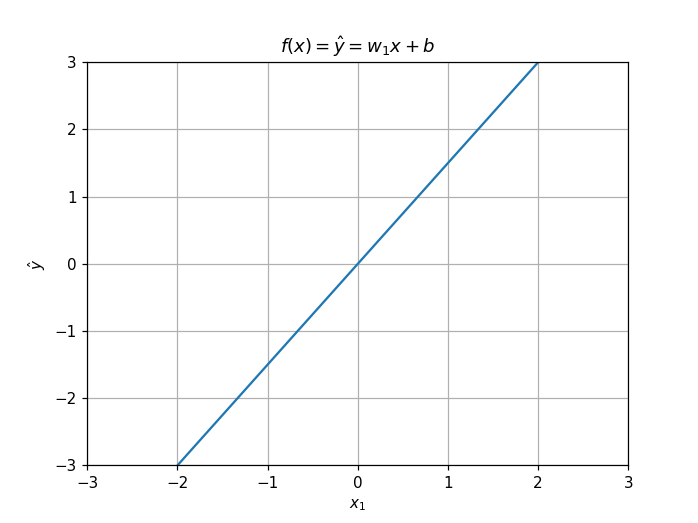

interactive(children=(FloatSlider(value=1.5, description='w1', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

In [2]:
plots.one_d_plot();

### Interactive Example with 2D Input

You can change the parameters for regression model for 2D input ($\mathbf{x} \in \mathbb{R}^2$) in the interactive plot below. This is the same model as before, only now it works in higher dimensional space. The model is defined by: $f(\mathbf{x}) = w_1x_1 + w_2x_2 + b$. Note that you can rotate the 3D visualization.

__Exercise 2.3:__ Play around with the parameter values. Before you try it, guess what happens when you set $w_1 = 0$ or $w_2 = 0$ or both $w_1 = w_2 = 0$? What is your interpretation of the model behavior for these cases?

__Exercise 2.4:__ How would you describe the family of functions that can be approximated by the linear regression model in this case with $\mathbf{x} \in \mathbb{R}^2$? Can you assume what would happen if we would not have a bias term in our definition?

<IPython.core.display.Javascript object>


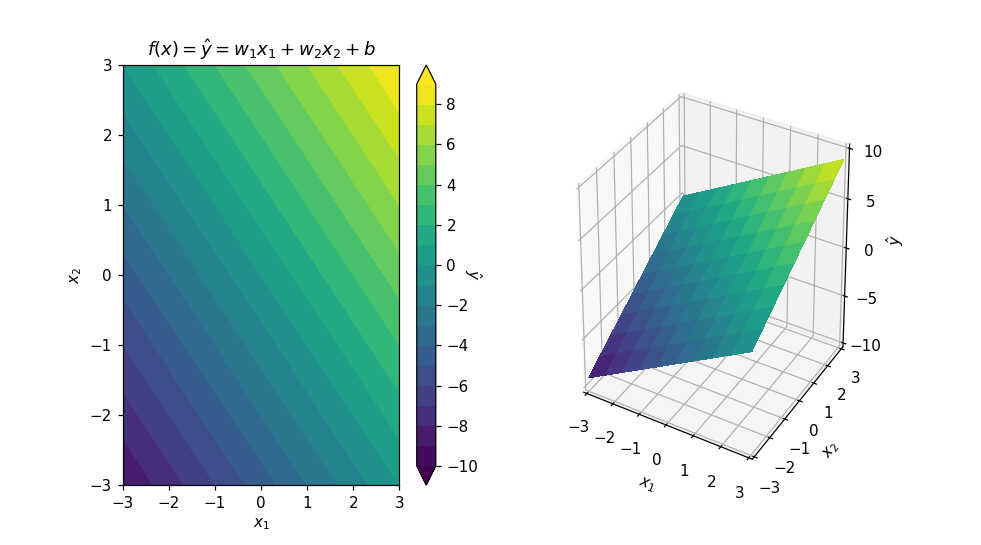

interactive(children=(FloatSlider(value=1.5, description='w1', max=3.0, min=-3.0), FloatSlider(value=1.5, desc…

In [3]:
plots.two_d_plot();

### Fitting the Data

We briefly analyzed what kinds of functions can be approximated by linear regression models. Now we address the issue of how to use these models to fit the data.

__Exercise 2.5:__ Try to find the optimal values of $w_1$ and $b$ to fit the data (red dots).

<IPython.core.display.Javascript object>


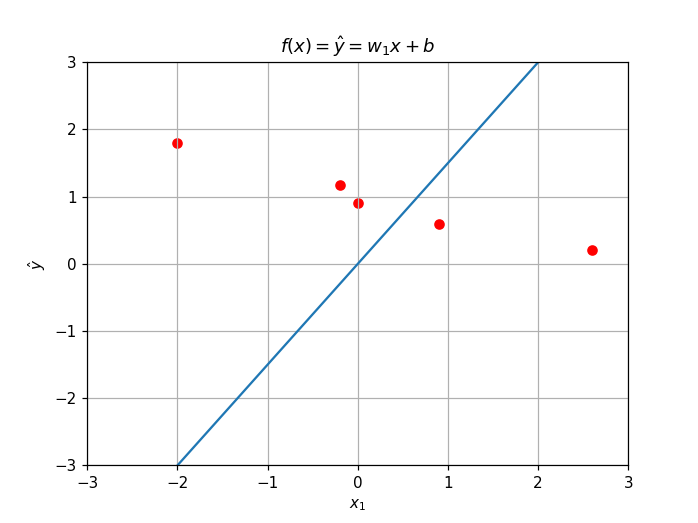

interactive(children=(FloatSlider(value=1.5, description='w1', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

In [4]:
plots.manual_fit_plot();

We can see that the linear model can fit the data quite well, but not perfectly. We are able to obtain perfect fit only rarely, usually when we have artificially generated data. Often the data generating process is more complicated and noisy. Machine learning models are usually approximators, rarely perfect fits.

Notice that it might be hard to decide which parameters are the best, e.g. in our example above, should $w_1$ be equal to $-0.4$ or $-0.3$ with $b = 1$? Both solutions are quite good and it seems hard to decide simply by looking at the graph. The prolem is that so far we use the term _fit the data_ intuitively. To proceed further, we must define a metric that will tell how good our solution is, i.e. how well we fit.

### Loss function

The metric used for optimization of models is called loss function (or also _cost function_ ). It is a function that maps the current solution (current parameter values) to a real valued score: $L: \mathbb{R}^{dim(\theta)} \rightarrow \mathbb{R}$. Often we first define the loss function for one sample, e.g. by using the square of the error:

\begin{equation}
L^{(i)}(\theta) = (\hat{y}^{(i)} - y^{(i)})^2
\end{equation}

Perfect prediction makes the loss function equal to zero. The worse the prediction, the higher the loss function value is. We are rarely interested in only one sample, usually we want to measure the performance on the whole dataset. Most often we use a mean of individual losses over $K$ samples. This particular loss function is also called mean squared error (MSE):

\begin{equation}
L(\theta) = \frac{\sum_{i=1}^K{L^{(i)}(\theta)}}{K} = \frac{\sum_{i=1}^K{(\hat{y}^{(i)} - y^{(i)})^2}}{K}
\end{equation}

Previously we did not have a precise definition of what does it mean to solve a regression task. Now we managed to reframe this question to a optimization problem: We hope that by minimizing the loss function $L$ we manage to find a near optimal regression solution. We minimize the loss function by searching for good values of model parameters $\theta$.

__Exercise 2.6:__ In the interactive plot below we now show the error for each point, as well as the total mean squared error. You can now compare the solutions with $w_1=-0.3, b=1$ and $w_1=-0.4, b=1$. Which one is better? Notice what happens with the error of the middle point when you change the $w_1$ parameter.

<IPython.core.display.Javascript object>


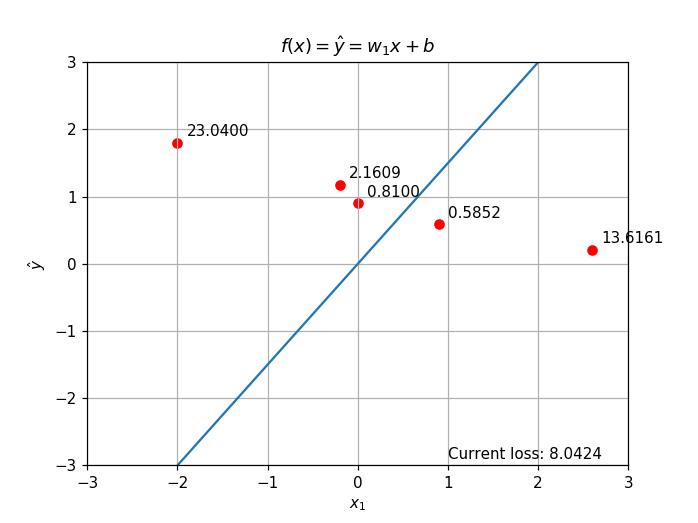

interactive(children=(FloatSlider(value=1.5, description='w1', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

In [5]:
plots.manual_fit_plot(show_loss=True);

__Optional Note:__ You might wonder why we use the square of the error as $L^{(i)}$ and not some other term, e.g. absolute error $|\hat{y}^{(i)} - y^{(i)}|$. In theory, we can use any loss function - and different loss functions might prefer different solutions. E.g. with absolute error $w_1=-0.4$ has a better score than $w_1=-0.3$ with $b=1$ in our example above. Each loss function has different mathematical properties. [This blog by Ben Kuhn](https://www.benkuhn.net/squared) is a nice read about some of the nice properties that MSE has.

## Gradient Descent

We have the model defined, as well as its loss function. Now we need to find out how to minimze the loss function by changing the values of parameters $\theta = \{\textbf{w}, b\}$. Gradient descent (GD) is a technique that is based around the idea of calculating derivatives of the loss function $L$ with respect to (w.r.t.) parameters $\theta$: this derivative is marked as $\frac{d L}{d \theta}$. Derivative of a function tells us the direction of the steepest ascent in the given point. If we move in opposite direction, we should find a point with smaller value.

The arrows in the plot below show _negative_ derivatives $-\frac{d f}{d (x, y)}$ in certain points. The direction of each arrow shows us where is the steepest descent in the point and its length shows us how steep it is.

<IPython.core.display.Javascript object>


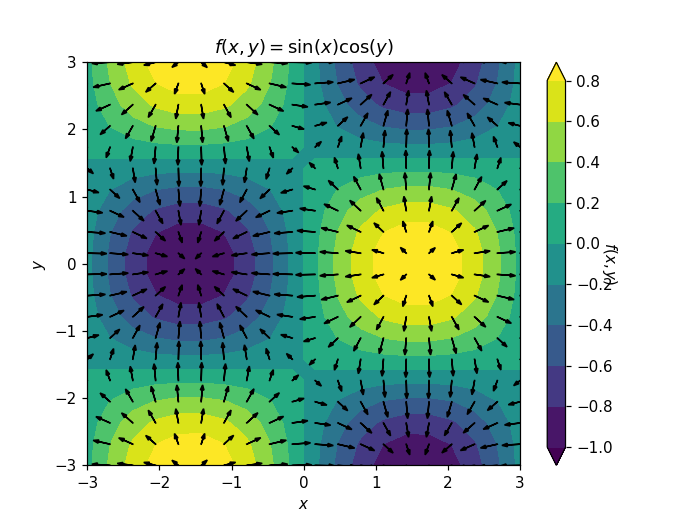

In [6]:
plots.derivatives_plot();

The general idea behind GD is that we can find local minima by following the "arrows", i.e. gradients. Outline of the GD is:

1. __Initialize the parameters to starting values $\theta_0$.__ Many initialization strategies exist. We will usually start with zero parameters in this lab.
2. __Calculate the gradient w.r.t. current parameters $\frac{d L}{d \theta_i}$.__
3. __Update the parameters with the gradient $\theta_{i+1} = \theta_i - \alpha \frac{d L}{d \theta_i}$.__ $\alpha$ is called _learning rate_ - it is a constant that is set before the algorithm by us.
4. __If the stopping criterium is not fulfilled, jump to step 2.__ E.g. when certain number of steps was done, when sufficient solution was found or when we detect that further training does not improve the performance anymore.

__Exercise 2.7__: Observe the behavior of gradient descent for simple quadratic function $f(x,y) = x^2 + 1.2y^2$. You can change the value of learning rate $\alpha$. What happens when it is set too low or too high? Find the derivatives of $\frac{d f}{d x}$ and $\frac{d f}{d y}$. How does the update rule (Step 3 from GD) looks like for this function? In this case the stopping criterium is 10 steps.

<IPython.core.display.Javascript object>


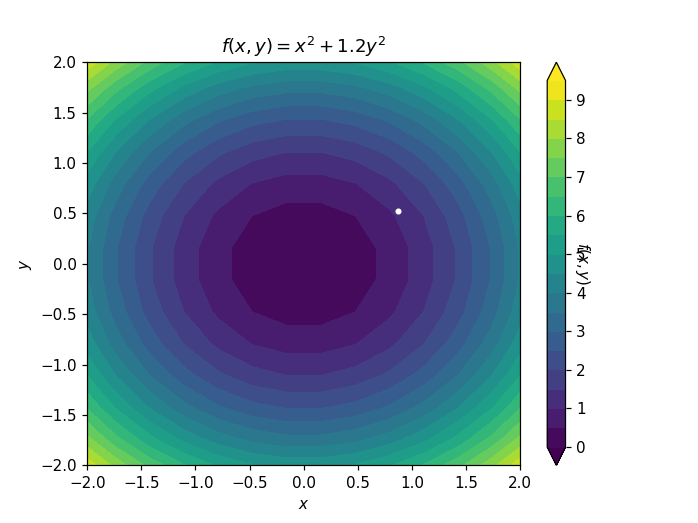

interactive(children=(Dropdown(description='alpha', options=(0.01, 0.3, 0.7, 1.2, 'custom'), value=0.01), Floa…

In [7]:
plots.gd_plot();

### Gradient Descent for Linear Regression

We can also apply the same algorithm for minimizing the loss function of logistic regression model. To do so we must be able to compute the gradients w.r.t parameters $\frac{d L}{d \theta}$. This is a rather math heavy section and it is not neccessary to understand this completely. However you should have an intuitive understanding that calculating the derivatives for parameter like this is possible. You can skip to Programming Assignment 2.9 and return to this part later.

\begin{equation}
\frac{d L}{d \theta} = \frac{d}{d \theta}\frac{\sum_{i=1}^K{L^{(i)}(\theta)}}{K}
=^1 \frac{1}{K}\frac{d}{d \theta}\sum_{i=1}^K{L^{(i)}}
=^2 \frac{1}{K}\sum_{i=1}^K{\frac{d L^{(i)}}{d \theta}}
\end{equation}

<sup>$^1$ We can do this because $(c \cdot f(x))' = c \cdot f(x)'$</sup>  
<sup>$^2$  $(f(x) + g(x))' = f(x)' + g(x)'$</sup>
    
We found out that the derivation of loss function w.r.t parameters is a mean of derivatives of losses for individual samples $L^{(i)}$. Next we need to find out the derivation for this sample loss:

\begin{equation}
\frac{d L^{(i)}}{d \theta} = \frac{d}{d \theta}(y^{(i)} - \hat{y}^{(i)})^2
=^3 2(y^{(i)} - \hat{y}^{(i)})\frac{d}{d \theta} (y^{(i)} - \hat{y}^{(i)})
=^4 -2(y^{(i)} - \hat{y}^{(i)})\frac{d}{d \theta} \mathbf{x}^{(i)} \cdot \mathbf{w} + b
\end{equation}

<sup>$^3$ $f(g(x))' = f'(g(x))\cdot g(x)'$ and $(x^2)' = 2x$</sup>   
<sup>$^4$ We removed $y$ because it is a constant ($c' = 0$) and took the minus from $-\hat{y}$ outside.</sup> 

It is easy to see that $\frac{d}{d \mathbf{w}}\mathbf{x} \cdot \mathbf{w} + b = \mathbf{x}$ because:

\begin{equation}
\frac{d}{dw_j} x_1w_1 + x_2w_2 + ... + x_nw_n + b = x_j
\end{equation}

From this we can see that:

\begin{equation}
\frac{d L^{(i)}}{dw_j} = -2(y^{(i)} - \hat{y}^{(i)})x^{(i)}_j
\end{equation}

This is the derivation term for sample loss function for each weight parameter. The mean of these terms for all the samples is the derivation of the $L$ w.r.t to $w_i$ and this mean can be applied for the gradient descent algorithm.

__Exercise 2.8:__ Find out $\frac{d L^{(i)}}{db}$ on your own.

### Programming assigment 2.9: Gradient Descent

You should now be able to program your own linear regression model and its gradient descent training. Open `model.py` file and complete the methods with `FIXME`. Tests are provided for the `LinearRegressionModel` class. Running `model.py` file should run the tests. If you pass all the tests, you can try to run your model in the interactive plot below.

Try following the notebook so far when solving the tasks. If you are not sure how to proceed, check the correct answers at the bottom of this page - they show the equations you should utilize in this assignment.

__Exercise 2.10__ Try changing the learning rate to different values, e.g. $\{0.43, 0.42, 0.3, 0.01\}$.

__Exercise 2.11:__ Compare your code with the description of GD algorithm above. Can you identify the four GD steps in the code?

In [8]:
from week_2.model import LinearRegressionModel

if tests.model_test():

    data = load_data('toy_1.csv')
    model = LinearRegressionModel(input_dim=1, learning_rate=0.2, w=[2], b=-2)
    plots.add_magic(model, speed=10)  # Visualization magic
    model.gradient_descent(data.x, data.y, num_steps=50)

EEEE
ERROR: test_compute_gradients (week_2.tests.model_test.TestLinearRegressionModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "../week_2/tests/model_test.py", line 49, in test_compute_gradients
    self.assertEqual(len(dw), 1)
TypeError: object of type 'ellipsis' has no len()

ERROR: test_loss (week_2.tests.model_test.TestLinearRegressionModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "../week_2/tests/model_test.py", line 76, in test_loss
    2.086875)
  File "/usr/lib/python3.6/unittest/case.py", line 871, in assertAlmostEqual
    if round(abs(second-first), places) == 0:
TypeError: unsupported operand type(s) for -: 'float' and 'ellipsis'

ERROR: test_predict (week_2.tests.model_test.TestLinearRegressionModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "../week_2/tests/mo

Apart from GD, specialized optimization techniques exist for some simple and well-known models, including [linear regression](https://en.wikipedia.org/wiki/Linear_regression#Estimation_methods). In practice, it might be an overkill to train linear regression with GD, because we can calculate the weights more conveniently with these algorithm. However, for us linear regression is only a starting point for further study of deep neural networks and those are usually trained by GD-based approaches.

### Stochastic Gradient Descent

Analyzing time complexity of gradient descent algorithm reveals that it consists of two nested loops. For each training step we need to calculate gradient for each sample. Other parts of training step are negligible. We can say say that each step has $O(K)$ time complexity. On top of that, the step is performed $J$ times before a stopping criteria are fullfilled. Total time complexity of GD is therefore $O(JK)$.

Number of steps $J$ needed is usually in the orders of $10^4 - 10^6$ for non-toy experiments. E.g. AlphaGo (2017) [did more than 3 million steps](https://www.nature.com/articles/nature24270) during its training, which took 40 days. Number of samples $$K for extensive datasets can also be in the order of $10^6$. It is obvious, that calculating the gradient for each sample would be simply too expensive, even for modern hardware.

In practice, *__stochastic__ gradient descent* or SGD is used instead. The main idea is to use only a subset of samples $S$ to calculate the gradient and use this as an approximation for the loss function:

\begin{equation}
\frac{\sum_{i \in S}{L^{(i)}(\theta)}}{|S|} \approx L(\theta) = \frac{\sum_{i=1}^K{L^{(i)}(\theta)}}{K}
\end{equation}

This subset is called minibatch or shortly _batch_. Its size $|S|$ is set before the training and it is called a _batch size_. In practice, batch size tends to be much smaller than $K$, usually in the orders of $10^0 - 10^3$ for smaller experiments.

The gradients calculated with these batches are only approximation of the true gradients and are less accurate. Theoretically we need to do __more__ steps with SGD because of this. However, the cost of calculating the gradients is much smaller and SGD is significantly faster to use. Therefore in practice, vanilla GD is never used for non-trivially big datasets.

__Optional Note:__ Even though GD seems to be more "correct", as it computes the true gradient of loss function, in practice it does not seem to have better results than SGD when applied to real data [1].

__Exercise 2.12:__ Explore the interactive plot below. The first 5 plots are loss functions for the 5 data points of the dataset we were fitting previously. The last plot is the overall loss function calculated as a mean of the 5. You should recognize it from previous visualizations. The arrows show the gradient for each function in given parameter point. With SGD with $|S| = 1$ we would use the gradients computed for randomly selected point instead of the mean for our parameter updates. Compare the gradients for individual data points (first 5 plots) to the overall _correct_ gradient calculated over the whole dataset (last plot). Observe the gradients in global minimum - you should know its coordinates from previous exercises.

In [ ]:
plots.stochastic_plot();

Samples for each step are pick randomly, using selection without replacement. This means that the dataset like a bag with balls, where each ball is a sample. We randomly select $|S|$ balls/samples and use them for training. Then we will __not__ return them to the bag. We continue sampling until the bag is empty and then we return all the balls/samples back. One iteration of this process is called _an epoch_.

In practice it is almost always implemented with shuffling. At the start of the epoch we shuffle the order of samples. Then we simply iteratate over the $|S|$-tuples. E.g. with batch size 5, we select the first 5 samples for the first training step. Then for the second step we select the second 5 samples, i.e. samples 6-10. We continue with this until we select all the 5-tuples. The table belows ilustrates where each sample $s_i$ belongs with different batch sizes over a dataset with 7 data points.

| Batch size | $s_1$ | $s_2$ | $s_3$ | $s_4$ | $s_5$ | $s_6$ | $s_7$ |
| :--------- | - | - | - | - | - | - | - |
| 1          | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
| 2          | 1 | 1 | 2 | 2 | 3 | 3 | 4 |
| 3          | 1 | 1 | 1 | 2 | 2 | 2 | 3 |
| 5          | 1 | 1 | 1 | 1 | 1 | 2 | 2 |

With this in mind, the general outline of SGD is as follows (compare it to the outline of GD):

1. __Initialize the parameters to starting values $\theta_0$.__ 
2. __Run an epoch.__
3. __If the stopping criterium is not fulfilled, jump to step 2.__

__Optional Reading:__ If you wonder why we need to shuffle the data before each epoch in the first place, you can check Chapter 8.1.3 in the _Deep Learning_ book. If you wonder why we sample the data without replacement, i.e. why we use each sample exactly once during each epoch, [this thread gives several possible reasons.](https://stats.stackexchange.com/questions/242004/why-do-neural-network-researchers-care-about-epochs)

### Programming Assignment 2.13: Stochastic Gradient Descent

Extend the `LinearRegressionModel` class with additional method: `stochastic_gradient_descent`. You can find the method signature in `sgd.py`. For each epoch shuffle the dataset and then perform steps over $|S|$-tupes using the `step` method you implemented earlier. Use number of epochs as stopping criterium.

__Exercise 2.14:__ Change the hyperparameters (learning rate, number of epochs and batch_size) in the code below and see how the models behave.

In [9]:
from solutions.week_2.model import LinearRegressionModel

if tests.sgd_test():
    
    learning_rate = 0.03
    num_epochs = 10
    batch_size = 1

    data = load_data('toy_1.csv')

    model_gd = LinearRegressionModel(input_dim=1, learning_rate=learning_rate, w=[2], b=-2)
    plots.add_magic(model_gd, speed=10)
    model_gd.stochastic_gradient_descent(data.x, data.y, num_epochs=num_epochs, batch_size=batch_size)

    model_sgd = LinearRegressionModel(input_dim=1, learning_rate=learning_rate, w=[2], b=-2)
    plots.add_magic(model_sgd, speed=10)
    model_sgd.gradient_descent(data.x, data.y, num_steps=num_epochs)

EEE
ERROR: test_batch_count (week_2.tests.sgd_test.TestSGD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "../week_2/tests/sgd_test.py", line 33, in test_batch_count
    self.model.stochastic_gradient_descent(*self.data, num_epochs=3, batch_size=2)
AttributeError: 'LinearRegressionModel' object has no attribute 'stochastic_gradient_descent'

ERROR: test_sample_coupling (week_2.tests.sgd_test.TestSGD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "../week_2/tests/sgd_test.py", line 48, in test_sample_coupling
    self.model.stochastic_gradient_descent(*self.data, num_epochs=3, batch_size=2)
AttributeError: 'LinearRegressionModel' object has no attribute 'stochastic_gradient_descent'

ERROR: test_shuffling (week_2.tests.sgd_test.TestSGD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "../wee

## Key Concepts from This Week

- Linear regression
- Bias term
- Loss function
- Mean squared error
- Gradient descent
- Learning rate
- Stochastic gradient descent
- Batch and batch size
- Epoch


## Further Reading

- Chapter 8.1 from the _Deep Learning_ book covers some additional topics related to SGD.

## Sources
[1] Wilson, D. R., & Martinez, T. R. (2003). The general inefficiency of batch training for gradient descent learning. Neural networks, 16(10), 1429-1451.

## Correct Answers

__E 2.1:__ Artificial neuron is usually defined as $\sigma(\textbf{w}\cdot\textbf{x} + b)$. Compared to linear regression there is an additional activation function $\sigma$. We can say that linear regression is a special case of artificial neuron with identity function used for activation $\sigma(x) = x$.

__E 2.2:__ All linear functions of one variable are the family for linear regression. This is not surprising as the definition is the same as the definition for general linear function $f(x) = ax + b$. This inludes all non-vertical lines in the 2D space. With no bias term, we have the family limited only to linear functions that cross the origin $\textbf{O} = [0, 0]$.

__E 2.4:__ All linear functions of two variables are the family here. This includes all the non-vertical planes in the 3D space. Again, with no bias term, all the planes would have to cross the origin point. With bias term we can shift the function surface up or down along the $\hat{y}$ axis.


__E 2.7:__ The derivatives are $\frac{d f}{d x} = 2x$ and $\frac{d f}{d y} = 2.4y$.

The update rule is:

\begin{equation}
 \begin{bmatrix}
  x_i \\ y_i
 \end{bmatrix} = \begin{bmatrix}
  x_{i-1} \\ y_{i-1}
 \end{bmatrix}- \alpha \begin{bmatrix}
  2x_{i-1} \\ 2.4y_{i-1}
 \end{bmatrix}
\end{equation}

__E 2.8:__ $-2(y^{(i)} - \hat{y}^{(i)})$

__P 2.9.1:__ Return the prediction as: $\hat{y} = \sum_{i=1}^{N}{x_i w_i} + b$

__P 2.9.2:__ Return tuple with derivative for $\mathbf{w}$ and $b$. Do not forget that $\mathbf{w}$ is a vector, not a scalar:

$\frac{dL}{dw_j} = \frac{1}{K}\sum_{i=1}^K-2(y^{(i)} - \hat{y}^{(i)})x^{(i)}_j$  
$\frac{dL}{db} = \frac{1}{K}\sum_{i=1}^K-2(y^{(i)} - \hat{y}^{(i)})$

__P 2.9.3:__ Apply the derivatives on current parameters, i.e. update the current parameters of the model: $\mathbf{w_i} = \mathbf{w}_{i-1} - \alpha\frac{dL}{dw_{i-1}}$ and $b_i = b_{i-1} - \alpha\frac{dL}{db_{i-1}}$

__P 2.9.4:__ Return loss function: $L(\theta) = \frac{\sum_{i=1}^K{(\hat{y}^{(i)} - y^{(i)})^2}}{K}$